<a href="https://colab.research.google.com/github/MainakRepositor/Data-Analysis/blob/master/Hotel_Reviews_Sentiment_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hotel Reviews Sentiment Prediction

<hr>

## 1. Importing necessary libaries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import seaborn as sns


import numpy as np 
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import random as rn

import re
print("Necessary packages have been included successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Necessary packages have been included successfully!


In [ ]:
seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

## 2. Importing the datasets

In [ ]:
url = 'https://raw.githubusercontent.com/MainakRepositor/Datasets-/master/tripadvisor_hotel_reviews.csv'
df = pd.read_csv(url,error_bad_lines=False)
df.head(10)

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
5,love monaco staff husband stayed hotel crazy w...,5
6,"cozy stay rainy city, husband spent 7 nights m...",5
7,"excellent staff, housekeeping quality hotel ch...",4
8,"hotel stayed hotel monaco cruise, rooms genero...",5
9,excellent stayed hotel monaco past w/e delight...,5


## 3. Exploring the data

In [ ]:
r,c = df.shape
print("Number of ratings in the dataset = ",r)
print("Number of columns in the dataset = ",c)

Number of ratings in the dataset =  20491
Number of columns in the dataset =  2


## 4. Checking for missing data

In [ ]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

Text(0.5, 1.0, 'Count of ratings \n')

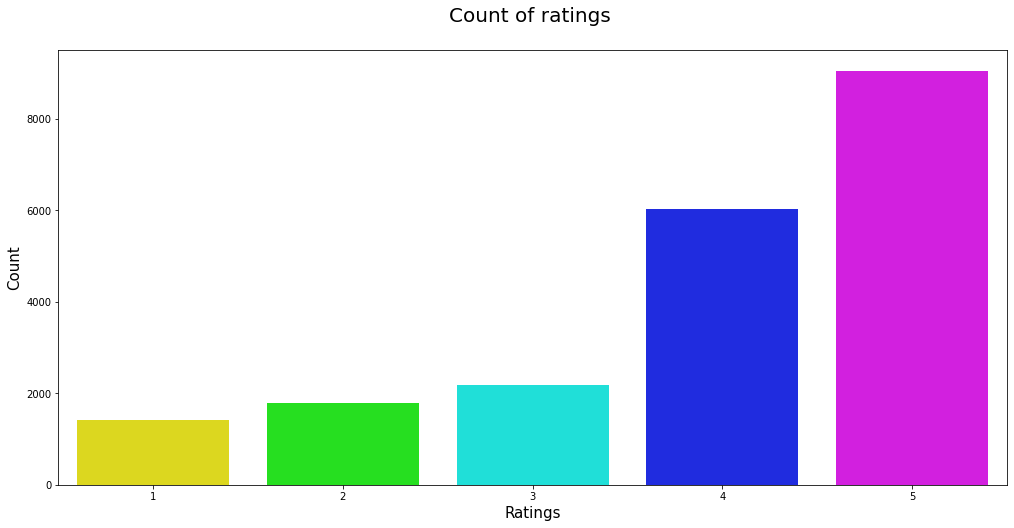

In [ ]:
plt.figure(figsize=(17,8))
sns.countplot(x='Rating',data=df,palette='hsv')
plt.xlabel('Ratings',size=15)
plt.ylabel('Count',size=15)
plt.title("Count of ratings \n",size=20)

In [ ]:
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 1800, height = 800,
                          background_color ='black',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    # plot the WordCloud image                        
    plt.figure(figsize = (18, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show() 

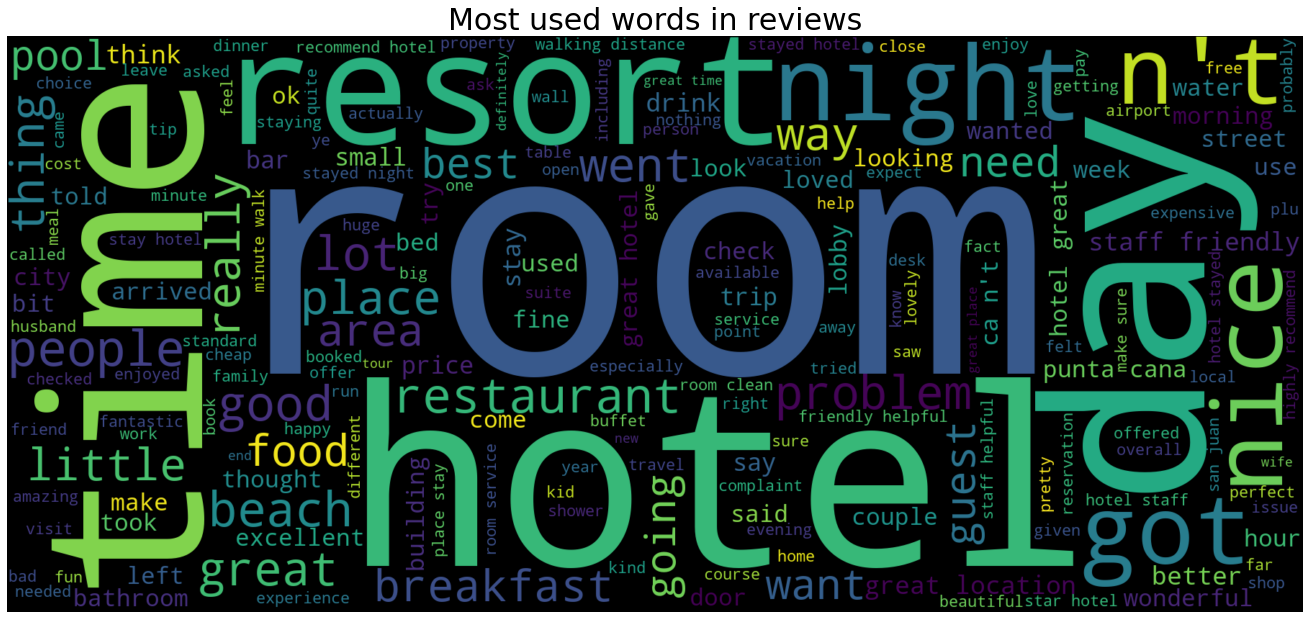

In [ ]:
wordCloud_generator(df['Review'], title="Most used words in reviews")

## 5. Creating the NLP Model

In [ ]:
X = df['Review'].copy()
y = df['Rating'].copy()

In [ ]:
def data_cleaner(review):
    
    # remove digits
    review = re.sub(r'\d+',' ', review)
    
    #removing stop words
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])
    
    #Stemming
    #review = " ".join([ps.stem(w) for w in review])
    
    return review

ps = PorterStemmer() 
stop_words = stopwords.words('english')

X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms * experience hotel monaco seattle g...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

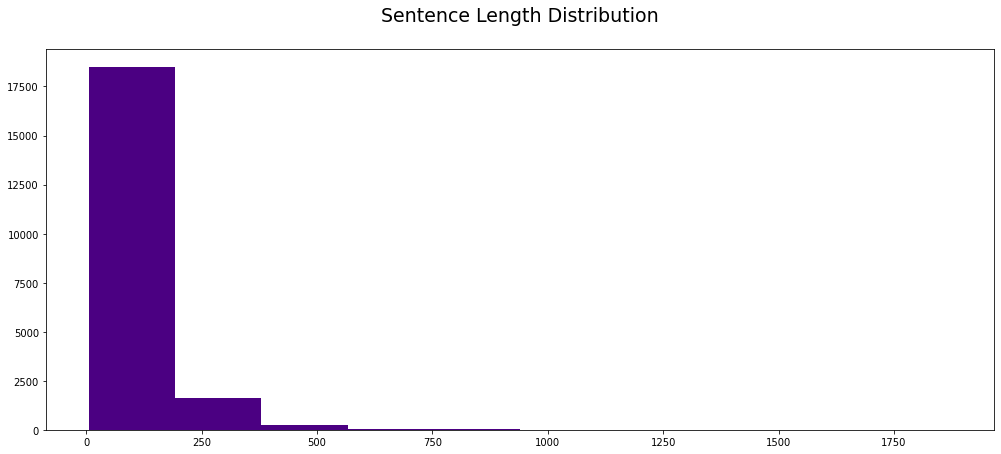

In [ ]:
length_dist = [len(x.split(" ")) for x in X_cleaned]
plt.figure(figsize=(17,7))
plt.hist(length_dist,color='indigo')
plt.title('Sentence Length Distribution\n',size=19)
plt.show()

## 6. Forming the tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1
exp_sen = 1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))
print("\nExample:\n")
print("Sentence:\n{}".format(X_cleaned[exp_sen]))
print("\nAfter tokenizing :\n{}".format(X[exp_sen]))

X = pad_sequences(X, padding='post', maxlen=350)
print("\nAfter padding :\n{}".format(X[exp_sen]))

Vocabulary size: 49536
max length of sentence: 1940

Example:

Sentence:
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution, send email trip guest survey follow email mail, guess tell concerned guest.the staff ranged indifferent helpful, asked desk good breakfast spots neighborhood hood told hotels, gee best breakfast spots seattle / block away convenient hotel know exist, arrived late

## 7. Categorical Encoding

In [ ]:
encoding = {1: 0,
            2: 1,
            3: 2,
            4: 3,
            5: 4
           }

labels = ['1', '2', '3', '4', '5']
           
y = df['Rating'].copy()
y.replace(encoding, inplace=True)

## 8. Splitting train and test cases

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=67, stratify=y
)

## 9. Forming the Deep Learning model for analysis

In [ ]:
# hyper parameters
EPOCHS = 3
BATCH_SIZE = 100
embedding_dim = 16
units = 76

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(5, activation="softmax")
])


model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 350, 16)           792576    
_________________________________________________________________
bidirectional (Bidirectional (None, 350, 152)          56544     
_________________________________________________________________
conv1d (Conv1D)              (None, 348, 64)           29248     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 174, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 11136)             0         
_________________________________________________________________
dropout (Dropout)            (None, 11136)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [ ]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/3
121/121 - 99s - loss: 1.2623 - accuracy: 0.4495 - val_loss: 0.9887 - val_accuracy: 0.5492
Epoch 2/3
121/121 - 99s - loss: 0.9410 - accuracy: 0.5737 - val_loss: 0.9207 - val_accuracy: 0.5667
Epoch 3/3
121/121 - 99s - loss: 0.7647 - accuracy: 0.6597 - val_loss: 0.9477 - val_accuracy: 0.5959


In [ ]:
pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
print('Accuracy: {}'.format(accuracy_score(pred, y_test)))

Accuracy: 0.6096406920005915


In [ ]:
print("Mean absolute error: {}".format(mean_absolute_error(pred,y_test)))

Mean absolute error: 0.44876534082507763


In [ ]:
print("Root mean square error: {}".format(np.sqrt(mean_squared_error(pred,y_test))))

Root mean square error: 0.7658811954988896


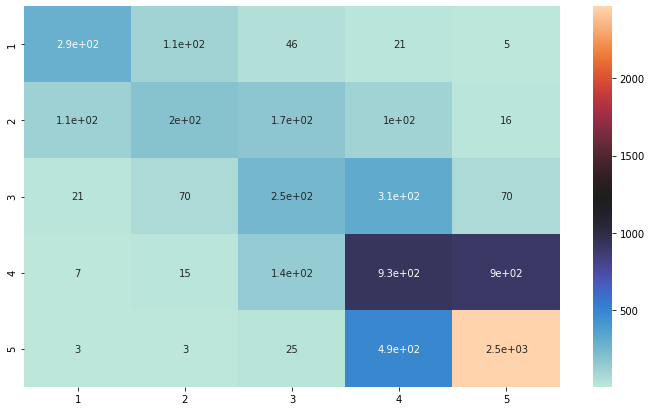

In [ ]:
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, cmap='icefire')
plt.show()

In [ ]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

           1       0.67      0.62      0.64       469
           2       0.50      0.33      0.40       592
           3       0.39      0.34      0.36       721
           4       0.50      0.47      0.48      1993
           5       0.71      0.83      0.77      2988

    accuracy                           0.61      6763
   macro avg       0.55      0.52      0.53      6763
weighted avg       0.59      0.61      0.60      6763

